# GEI723, Université de Sherbrooke, Nov. 2020
# Problème de classification de caractère manuscrits

Ce notebook est une adaptation de la classification par STDP de MNIST par Diehl & Cook, créé par I. Balafrej pour l'automne 2019, et adapté par A. El Ferdaoussi pour l'automne 2020.

L'article de Diehl & Cook est disponible ici: https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full

Ce code a été complété et adapté par 

* ETTAHI Yahya (CIP:etty2601)
* WAHBI Yasmine (CIP:wahy3501)
* YARGA Arnaud (CIP:yars2201)

Il s'articule suivant le plan suivant :

* Importation des données
* Création du réseau de neurones
* Entrainement du réseau
* Labelisation des neurones
* Validation

In [1]:
import numpy as np
from sklearn import datasets, model_selection
from brian2 import *
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\asus\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
INFO       Cache size for target "cython": 5562 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\asus\.cython\brian_extensions" directory. [brian2]


## 1- Importation des données

On télécharge l'ensemble de données MNIST directement dans le code. MNIST est disponible à https://www.openml.org/d/554

In [2]:
X_all, y_all = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, data_home=None)

MNIST est constituté de 70k d'images de 28x28 pixels, de chiffres.

'X' est le vecteur d'images, et 'y' est le vecteur d'étiquettes (labels).

In [3]:
X_all.shape, y_all.shape

((70000, 784), (70000,))

La simulation avec toutes les images est assez longue à faire rouler. Utilisons uniquement un sous-ensemble de MNIST pour une simulation plus rapide. Nous avons donc choisi les 10000 premières images.

In [4]:
nb_data = 10000
X = X_all[:nb_data]
y = y_all[:nb_data]

Divisons MNIST en ensembles d'entrainement et de validation pour entrainer et tester le modèle post-apprentissage.

Nous prenons 8000(80%) pour l'apprentissage et 2000(20%) pour la validation

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2)

Dessinons une image aléatoire de l'ensemble de données pour voir ce à quoi ressemble MNIST.

Les images dans MNIST sont des vecteurs. Il faut donc les ré-organiser en matrice 28x28 pour les afficher.

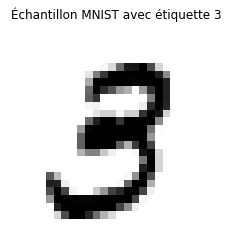

In [6]:
index = np.random.randint(0, len(X_train)-1)

plt.figure()
plt.axis('off')
plt.imshow(X_train[index].reshape(28, 28), cmap=plt.cm.gray_r)
plt.title("Échantillon MNIST avec étiquette %s" % y_train[index]);

## 2- Création du réseau de neurones

On peut maintenant créer un réseau Brian2. Commençons par définir quelques paramètres.
Les valeurs des taux d'apprentissage, ont été inspiré du code de Peter Diehl (https://github.com/peter-u-diehl/stdp-mnist) et ajouté par ETTAHI Yahya

In [7]:
# Fixons le seed aléatoire afin de pouvoir reproduire les résultats
np.random.seed(0)

# Horloge de Brian2
defaultclock.dt = 0.5 * units.ms

# Cible de génération de code pour Brian2
prefs.codegen.target = 'cython'

time_per_sample =   0.35 * units.second
resting_time = 0.15 * units.second

v_rest_e = -65. * units.mV 
v_rest_i = -60. * units.mV 

v_reset_e = -65. * units.mV
v_reset_i = -45. * units.mV

v_thresh_e = -52. * units.mV
v_thresh_i = -40. * units.mV

refrac_e = 5. * units.ms
refrac_i = 2. * units.ms

tc_theta = 1e7 * units.ms
theta_plus_e = 0.05 * units.mV

tc_pre_ee = 20 * units.ms
tc_post_1_ee = 20 * units.ms
tc_post_2_ee = 40 * units.ms

# Taux d'apprentissage
nu_ee_pre =  0.0001
nu_ee_post = 0.001

#Nombre des neurones excitateurs et inhibiteurs
nb_ex = 100
nb_inhi = nb_ex

#poids maximum
wmax = 10.0

Définissons l'entrée au réseau de neurones. L'entrée est un encodeur de type codage par fréquence. On utilise ici une variante des PoissonGroup de Brian2 comme mentionné dans la documentation https://brian2.readthedocs.io/en/latest/user/input.html#setting-rates-for-poisson-inputs

Par YARGA Arnaud

In [8]:
input_group = NeuronGroup(28*28, 'rates : Hz', threshold='rand()<rates*dt')

Définissons notre modèle de neurone ainsi que nos groupes de neurones.

L'équation des seuil a été inspiré du code de Peter Diehl (https://github.com/peter-u-diehl/stdp-mnist) par ETTAHI Yahya
La variable de l'homéostasie a été ajouté par YARGA Arnaud


In [9]:
neuron_model = '''
    dv/dt = ((v_rest_e - v) + (I_synE + I_synI) / nS) / tau  : volt (unless refractory)

    I_synE =  ge * nS * -v           : amp
    
    I_synI =  gi * nS * (d_I_synI-v) : amp
    
    dge/dt = -ge/(1.0*ms)            : 1
    
    dgi/dt = -gi/(2.0*ms)            : 1
    
    tau                              : second (constant, shared)
    
    d_I_synI                         : volt (constant, shared)
    
    dtheta/dt = -theta / (tc_theta)  : volt
    
    homeosthasy : boolean (shared) # Activer/désactiver l'homéosthasie
'''

excitatory_group = NeuronGroup(
    N=nb_ex, model=neuron_model, refractory=refrac_e, 
    threshold='v>(v_thresh_e- 20.0*mV+theta*int(homeosthasy))', reset='v=v_reset_e; theta += theta_plus_e', method='euler')
excitatory_group.tau = 100 * units.ms
excitatory_group.d_I_synI = -100. * units.mV
excitatory_group.homeosthasy = True

inhibitory_group = NeuronGroup(
    N=nb_inhi, model=neuron_model, refractory=refrac_i, 
    threshold='v>(v_thresh_i)', reset='v=v_reset_i', method='euler')
inhibitory_group.tau = 10 * units.ms
inhibitory_group.d_I_synI = -85. * mV

Et les synapses.

Pour le modèle STDP Triplet, il a été inspiré du code de Peter Diehl (https://github.com/peter-u-diehl/stdp-mnist) ainsi que du tutoriel de brian2 (https://brian2.readthedocs.io/en/stable/examples/frompapers.Clopath_et_al_2010_homeostasis.html). Complété par ETTAHI Yahya

Les connexions synaptiques ont été complétées par WAHBI Yasmine


In [10]:
synapse_model = "w : 1"

stdp_synapse_model = '''
    w : 1

    plastic : boolean (shared) # Activer/désactiver la plasticité
    
    post2before : 1
    
    dpre/dt   =   -pre/(tc_pre_ee)         : 1 (event-driven)
    
    dpost1/dt  = -post1/(tc_post_1_ee)     : 1 (event-driven)
    
    dpost2/dt  = -post2/(tc_post_2_ee)     : 1 (event-driven)
'''

stdp_pre = '''
    ge_post += w
    
    pre = 5. * int(plastic)
    
    w = clip(w + nu_ee_pre * post1 * int(plastic), 0, wmax)
'''

    
stdp_post = '''
    post2before = post2
    
    w = clip(w + nu_ee_post * pre * post2before * int(plastic), 0, wmax)
    
    post1 = -5. * int(plastic)
    
    post2 = 5. * int(plastic)
'''


input_synapse = Synapses(input_group, excitatory_group, model=stdp_synapse_model, on_pre=stdp_pre, on_post=stdp_post)
input_synapse.connect(True) # Fully connected
input_synapse.plastic = True
input_synapse.w = 'rand() * wmax'

e_i_synapse = Synapses(excitatory_group, inhibitory_group, model=synapse_model, on_pre='ge_post += w')
e_i_synapse.connect(condition='i == j')
e_i_synapse.w = 'rand()*10.4'

i_e_synapse = Synapses(inhibitory_group, excitatory_group, model=synapse_model, on_pre='gi_post += w')
i_e_synapse.connect(condition='i != j')
i_e_synapse.w = '17.0'

Combien de synapses a-t-on dans le réseau?

In [11]:
print(len(input_synapse) + len(e_i_synapse) + len(i_e_synapse))

88400


Définissons un 'readout' pour notre réseau.

In [12]:
e_monitor = SpikeMonitor(excitatory_group, record=False)

Créons le réseau.

In [13]:
net = Network(input_group, excitatory_group, inhibitory_group, 
              input_synapse, e_i_synapse, i_e_synapse, e_monitor)

## 3- Entrainement

Entrainons à présent notre réseau sur les 8000 données d'apprentissage.

Pour la normalisation, nous nous sommes inspirés de cet article (https://link.springer.com/chapter/10.1007/978-3-030-50153-2_57) et complété par ETTAHI Yahya

In [14]:
import time

# Entrainement
number_of_epochs = 1

# gardons une trace de l'évolution des poids
weight_history = []
start_time = time.time()
for i in range(number_of_epochs):
    print('Starting iteration %i' % i)
    for j, (sample, label) in enumerate(zip(X_train, y_train)):
        # Afficher régulièrement l'état d'avancement
        if (j % 200) == 0:
            print("Running sample %i out of %i" % (j, len(X_train)))
        
        # Configurer le taux d'entrée
        input_group.rates = (sample/4) * units.Hz
        
        # Simuler le réseau
        net.run(time_per_sample)
        
        # Arrêter l'entrée
        input_group.rates = 0 * units.Hz
        
        # Laisser les variables retourner à leurs valeurs de repos
        net.run(resting_time)
        
        # Normaliser les poids
        weight_matrix = np.zeros([len(input_group), len(excitatory_group)])
        weight_matrix[input_synapse.i, input_synapse.j] = input_synapse.w
        sumCol = np.sum(weight_matrix, axis=0)
        colFactors = 78/sumCol
        for jj in range(len(excitatory_group)):
            weight_matrix[:,jj] *= colFactors[jj]
        input_synapse.w = weight_matrix[input_synapse.i, input_synapse.j]
        if (j % 100) == 0:
            weight_history.append(weight_matrix.T)

duration = (time.time() - start_time)/60
print("TRAINING --- %s minutes ---" % duration)

Starting iteration 0
Running sample 0 out of 8000
Running sample 200 out of 8000
Running sample 400 out of 8000
Running sample 600 out of 8000
Running sample 800 out of 8000
Running sample 1000 out of 8000
Running sample 1200 out of 8000
Running sample 1400 out of 8000
Running sample 1600 out of 8000
Running sample 1800 out of 8000
Running sample 2000 out of 8000
Running sample 2200 out of 8000
Running sample 2400 out of 8000
Running sample 2600 out of 8000
Running sample 2800 out of 8000
Running sample 3000 out of 8000
Running sample 3200 out of 8000
Running sample 3400 out of 8000
Running sample 3600 out of 8000
Running sample 3800 out of 8000
Running sample 4000 out of 8000
Running sample 4200 out of 8000
Running sample 4400 out of 8000
Running sample 4600 out of 8000
Running sample 4800 out of 8000
Running sample 5000 out of 8000
Running sample 5200 out of 8000
Running sample 5400 out of 8000
Running sample 5600 out of 8000
Running sample 5800 out of 8000
Running sample 6000 out of

## 4- Labelisation des neurones

Maintenant que le réseau a appris et a fixé les poids, nous utilisons ici la moitié des données d'apprentissage afin d'attribuer une classe à chaque neurones.
Pour cela nous accumulons dans la matrice spike le décompte de décharge par classe de chaque neurone.

Proposé par YARGA Arnaud

In [15]:
# Déasctiver la plasticité STDP
input_synapse.plastic = False
spikes = np.zeros((10, len(excitatory_group)))
old_spike_counts = np.zeros(len(excitatory_group))
old_spike_counts = np.copy(e_monitor.count)

nb = int(0.5*len(y_train))
X_labeling = X_train[:nb]
y_labeling = y_train[:nb]
start_time = time.time()
for j, (sample, label) in enumerate(zip(X_labeling, y_labeling)):
    # Afficher régulièrement l'état d'avancement
    if (j % 100) == 0:
        print("Labeling sample %i out of %i" % (j, len(X_labeling)))

    # Configurer le taux d'entrée
    input_group.rates = (sample/4) * units.Hz

    # Simuler le réseau
    net.run(time_per_sample)

    # Enregistrer les décharges
    spikes[int(label)] += e_monitor.count - old_spike_counts
    # Gardons une copie du décompte de décharges pour pouvoir calculer le prochain
    old_spike_counts = np.copy(e_monitor.count)

    # Arrêter l'entrée
    input_group.rates = 0 * units.Hz

    # Laisser les variables retourner à leurs valeurs de repos
    net.run(resting_time)

duration = (time.time() - start_time)/60
print("LABELING --- %s minutes ---" % duration)

Labeling sample 0 out of 4000
Labeling sample 100 out of 4000
Labeling sample 200 out of 4000
Labeling sample 300 out of 4000
Labeling sample 400 out of 4000
Labeling sample 500 out of 4000
Labeling sample 600 out of 4000
Labeling sample 700 out of 4000
Labeling sample 800 out of 4000
Labeling sample 900 out of 4000
Labeling sample 1000 out of 4000
Labeling sample 1100 out of 4000
Labeling sample 1200 out of 4000
Labeling sample 1300 out of 4000
Labeling sample 1400 out of 4000
Labeling sample 1500 out of 4000
Labeling sample 1600 out of 4000
Labeling sample 1700 out of 4000
Labeling sample 1800 out of 4000
Labeling sample 1900 out of 4000
Labeling sample 2000 out of 4000
Labeling sample 2100 out of 4000
Labeling sample 2200 out of 4000
Labeling sample 2300 out of 4000
Labeling sample 2400 out of 4000
Labeling sample 2500 out of 4000
Labeling sample 2600 out of 4000
Labeling sample 2700 out of 4000
Labeling sample 2800 out of 4000
Labeling sample 2900 out of 4000
Labeling sample 3000 o

Après le décompte, nous pouvons attribuer une classe à chaque neurone en observant la classe pour laquelle il a eu le plus de décharge

Proposé par YARGA Arnaud

[[0 0 9 6 5 7 0 2 8 9]
 [2 0 2 4 9 3 2 3 3 6]
 [6 9 0 5 3 7 0 2 6 3]
 [6 2 0 4 3 0 8 6 0 3]
 [7 9 0 3 1 3 0 4 1 6]
 [0 0 6 0 6 1 0 8 3 6]
 [2 7 0 8 8 0 3 8 8 6]
 [0 0 8 3 9 4 5 2 2 0]
 [3 8 7 6 0 3 4 9 0 0]
 [0 4 2 2 0 0 2 7 3 8]]


([<matplotlib.axis.XTick at 0x1f65ffdd5e0>,
 <a list of 10 Text major ticklabel objects>)

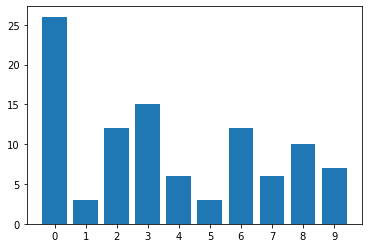

In [67]:
labeled_neurons = np.argmax(spikes, axis=0)

print(labeled_neurons.reshape(10,10))

b = np.bincount(labeled_neurons)
bar(range(len(b)),b)
xticks(range(len(b)))

#### Visualisation des champs récepteurs

Visuellement on peut constater que le choix des classes des neurones est en accord avec les champs récepteurs

Proposé par YARGA Arnaud

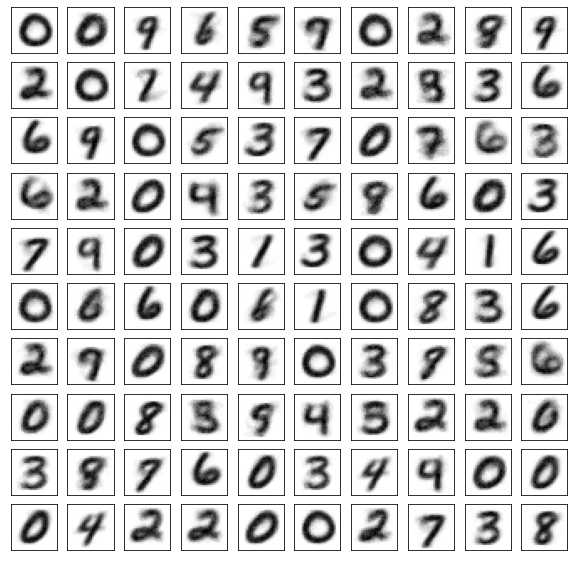

In [17]:
plt.figure(figsize=(10,10))
for u in range(10):
    for v in range(10):
        ax = plt.subplot2grid((10,10),(u,v))
        ax.imshow(weight_history[-1][u*10+v].reshape(28, 28), cmap=plt.cm.gray_r)
        plt.xticks([])
        plt.yticks([])
plt.show()

### Courbes d'accord
Sur la base de la matrice spikes, nous pouvons tracer une courbe d'accord représentant le nombre de décharge par classe de chaque neurone. D'abord nous normalisons la matrice spikes en divisant le nombre de décharge de chaque classe par le nombre d'images appartenant à cette classe.

Proposé par ETTAHI Yahya

In [37]:
spikes_normalize = np.copy(spikes)
nb_img = [int(x) for x in y_labeling]
count_nb = b = np.bincount(nb_img)
for c in range(len(spikes_normalize)):
    spikes_normalize[c] /= count_nb[c]
spikes_normalize_t = spikes_normalize.T


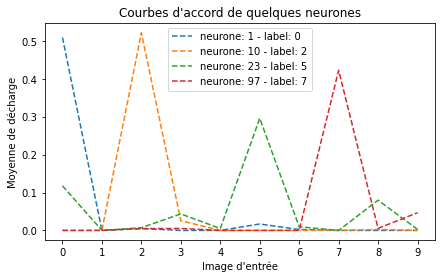

In [54]:
plt.figure(figsize=(7,4))
plt.title("Courbes d'accord de quelques neurones")
neurone_to_visualize = [1,10,23,97]
for neur in neurone_to_visualize:
    plot(spikes_normalize_t[neur], '--',label="neurone: {} - label: {}".format(neur,labeled_neurons[neur]))
plt.xticks(np.arange(10))
plt.xlabel("Image d'entrée")
plt.ylabel("Moyenne de décharge")
plt.legend()
plt.show()

#### Historique de l'évolution du champ récepteur d'un neurone

Proposé par WAHBI Yasmine

Evolution du champ récepteur du neurone excitateur: 13 - Label : 4


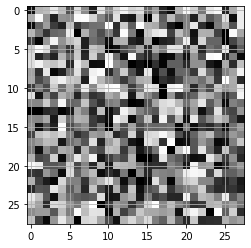

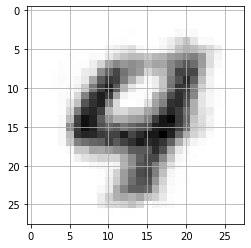

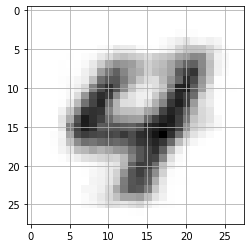

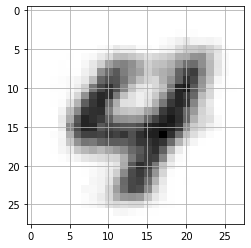

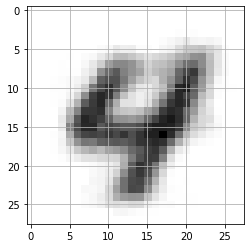

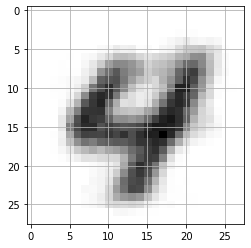

In [66]:
nb=13
print("Evolution du champ récepteur du neurone excitateur: {} - Label : {}".format(nb, labeled_neurons[nb]));
for x in range(6):
    plt.figure()
    plt.imshow(weight_history[x*10][nb].reshape(28, 28), cmap=plt.cm.gray_r)
    plt.grid()
    plt.show()

## 5- Validation

Testons à présent le réseau entrainé grace à nos 2000 données de validation. Pour classer une image, on la présente à notre réseau, puis on compte le nombre de décharge de chaque neurones. La classe est donc celle du neurone ayant le déchargé le plus.

Complété par WAHBI Yasmine

In [19]:
# Déasctiver la plasticité STDP
input_synapse.plastic = False

num_correct_output = 0

start_time = time.time()
for i, (sample, label) in enumerate(zip(X_test, y_test)):
    # Afficher régulièrement l'état d'avancement
    if (i % 100) == 0:
        print("Running sample %i out of %i" % (i, len(X_test)))
    
    # Configurer le taux d'entrée
    # ATTENTION, vous pouvez utiliser un autre type d'encodage
    input_group.rates = (sample / 4) * units.Hz
    
    # Simuler le réseau
    net.run(time_per_sample)
    
    # Calculer le nombre de décharges pour l'échantillon
    current_spike_count = e_monitor.count - old_spike_counts
    # Gardons une copie du décompte de décharges pour pouvoir calculer le prochain
    old_spike_counts = np.copy(e_monitor.count)
    
    # Prédire la classe de l'échantillon
    output_label = labeled_neurons[np.argmax(current_spike_count)]
    
    # Si la prédiction est correcte
    if output_label == int(label):
        num_correct_output += 1
        
    # Laisser les variables retourner à leurs valeurs de repos
    net.run(resting_time)

duration = (time.time() - start_time)/60
print("TESTING --- %s minutes ---" % duration)
print("The model accuracy is : %.3f" % (num_correct_output / len(X_test)))

Running sample 0 out of 2000


WARNING    "v" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "v" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running sample 100 out of 2000
Running sample 200 out of 2000
Running sample 300 out of 2000
Running sample 400 out of 2000
Running sample 500 out of 2000
Running sample 600 out of 2000
Running sample 700 out of 2000
Running sample 800 out of 2000
Running sample 900 out of 2000
Running sample 1000 out of 2000
Running sample 1100 out of 2000
Running sample 1200 out of 2000
Running sample 1300 out of 2000
Running sample 1400 out of 2000
Running sample 1500 out of 2000
Running sample 1600 out of 2000
Running sample 1700 out of 2000
Running sample 1800 out of 2000
Running sample 1900 out of 2000
TESTING --- 198.87955631017684 minutes ---
The model accuracy is : 0.418


### Sauvegarde

Lorsque les résultats obtenues lors de la validation sont intéressants, on peut sauvegarder de manière permanente nos poids, nos labels et l'historique des poids.

Proposé par YARGA Arnaud

In [21]:
'''import pickle
with open('weightfile', 'wb') as fp:
    pickle.dump(weight_matrix, fp)
with open('weightHistoryfile', 'wb') as fp:
    pickle.dump(weight_history, fp)
with open('labelfile', 'wb') as fp:
    pickle.dump(labeled_neurons, fp)'''